In [1]:
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import subprocess
import json
import os
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, auc, roc_curve
from sklearn.externals import joblib
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer
from plotting import plot_confusion_matrix, plot_roc, plot_scores, plot_precision_recall, plot_feature_importance, plot_information_gain, plot_multilabel_confusion_matrix, plot_multilabel_precision_recall, plot_multilabel_roc
from preprocessing import FeatureSelector, TagGrouper, flatten_multilabel_predict_proba
import warnings
warnings.filterwarnings(action='once')

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Import dataset
df = pd.read_csv('./data/features-total-2f8f6676.csv', index_col='revision_id')
tag_df = pd.read_csv('./data/tag.csv', index_col='id')
df.head()

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,authorRank,authorRankOfLast200Edits,authorRankOneMonth,...,rawCommentLength,userCommentLength,hasNumericOutlierInColumns,hasNumericOutlierInRows,tableDataTypeInformationGain,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,tag_id
revision_id,,,,,,,,,,,,,,,,,,,,,
228189784,0.0,0.0,13.0,-1.0,7.0,-1.0,0.0,0.000000,0.000000,0.0,...,34.0,34.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,12
730449352,0.0,0.0,2.0,-1.0,2.0,-1.0,0.0,0.833333,0.857143,0.5,...,14.0,0.0,1.0,0.0,0.134129,0.0,0.0,0.0,0.0,12
216224416,0.0,0.0,17.0,-1.0,6.0,-1.0,1.0,0.000000,0.000000,0.0,...,67.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,12
539338621,0.0,1.0,1.0,-1.0,4.0,-1.0,1.0,0.000000,0.000000,0.0,...,152.0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,12
746191686,1.0,0.0,20.0,23.0,2.0,2.0,0.0,-1.000000,-1.000000,-1.0,...,10.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,12


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


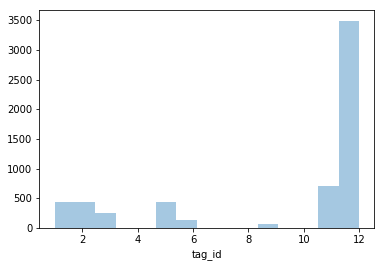

In [3]:
# Tag distribution
sns.distplot(df['tag_id'], kde=False)
plt.show()

In [4]:
BASELINE_FEATURE_COLUMNS = [
    # Context
    'isContributorAnonymous',
    'commentLength',
    'sizeChange',
    'timeSinceLastArticleEdit',
    'timeOfDay',
    'dayOfWeek',
    'timeSinceFirstArticleEditBySameContributor',
    'timeSinceContributorRevertedBeforeInThatArticle',
    'sizeRatio',
    'hasPreviousSameContributor',
    # Text
    'ratioOfNumericalCharsToAllChars',
    'ratioOfAlphanumericCharsToAllChars',
    'ratioOfUppercaseCharsToAllChars',
    'ratioOfUppercaseCharsToLowercaseChars',
    'lengthOfLongestConsecutiveSequenceOfSingleChar',
    'lengthOfLongestToken',
    'averageRelativeFrequencyOfNewAddedWords',
    'LZWCompressionRate',
    'KLDOfCharDistribution',
    'previousLength',
    # Language
    'vulgarWordFrequencyInComment',
    'vulgarWordFrequencyInTables',
    'vulgarWordImpactInTables',
    'personalPronounFrequencyInComment',
    'personalPronounFrequencyInTable',
    'personalPronounImpactInTable',
    # Ref: Colloquial, high bias
    'superlativeWordFrequencyInComment',
    'superlativeWordFrequencyInTable',
    'superlativeWordImpactInTable',
    'sexualWordFrequencyInComment',
    'sexualWordFrequencyInTables',
    'sexualWordImpactInTables',
    'averageAllBadWordFrequencyInComment',
    'averageAllBadWordFrequencyInTable',
    'averageAllBadWordImpactInTable',
    # Ref: Good words
    'wikiSyntaxElementFrequencyInTable',
    'wikiSyntaxElementImpactInTable',
    'wikiSyntaxElementFrequencyInComment',
    'revertInComment'
]

---
## Preprocessing

In [5]:
class TagGrouper2(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['all_tags'] = X.groupby(['revision_id'])['tag_id'].apply(list)
        X = X.drop(['tag_id'], axis=1)
        X = X.groupby(['revision_id']).first()
        return X

    def fit_transform(self, X, y):
        return self.transform(X)


def preprocessing(features):
    feature_columns = None
    
    if features == 'baseline':
        feature_columns = BASELINE_FEATURE_COLUMNS

    preprocess_pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_columns)),
        ('tag_grouper', TagGrouper2())
    ])

    return preprocess_pipeline.transform(df)
    
widget = interactive(preprocessing, features=['all', 'baseline'])
display(widget)

tags = [1, 2, 3, 5, 6, 9, 11, 12]
tag_names = ['blanking', 'nonesense', 'quality issue', 'false fact', 'syntax', 'edit war', 'intention', 'constructive']
print('Selected tags', tags)

interactive(children=(Dropdown(description='features', options=('all', 'baseline'), value='all'), Output()), _…

Selected tags [1, 2, 3, 5, 6, 9, 11, 12]


In [6]:
processed_df = widget.result
print('Feature config:', widget.kwargs['features'], ', Features after preprocessing:', len(processed_df.columns))
processed_df.head()

Feature config: all , Features after preprocessing: 109


,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,authorRank,authorRankOfLast200Edits,authorRankOneMonth,...,rawCommentLength,userCommentLength,hasNumericOutlierInColumns,hasNumericOutlierInRows,tableDataTypeInformationGain,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,all_tags
revision_id,,,,,,,,,,,,,,,,,,,,,
2148821,0.0,0.0,16.0,-1.0,1.0,-1.0,1.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[12]
2359434,0.0,0.0,0.0,-1.0,3.0,-1.0,0.0,0.666667,0.666667,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,[12]
2880168,0.0,0.0,3.0,-1.0,1.0,-1.0,0.0,0.000000,0.000000,0.0,...,5.0,5.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,[12]
2970351,0.0,0.0,22.0,-1.0,7.0,-1.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,[12]
2975763,1.0,0.0,0.0,18.0,2.0,1.0,0.0,-1.000000,-1.000000,-1.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,"[2, 11, 1]"


In [8]:
# X, y split
X = processed_df.drop(['all_tags'], axis=1)
y = MultiLabelBinarizer().fit_transform(processed_df['all_tags'])

In [9]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X train', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)

X train (3720, 108)
y train (3720, 8)
X test (1240, 108)
y test (1240, 8)


In [ ]:
clf = RandomForestClassifier(n_estimators=500)
train_scores = cross_validate(clf, X_train, y_train,
                              scoring=['f1_micro', 'precision_micro', 'recall_micro', 'roc_auc'],
                              cv=10, n_jobs=-1, return_train_score=False)

y_train_predict = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict')

In [ ]:
plot_scores(train_scores)

In [ ]:
plot_multilabel_confusion_matrix(y_train, y_train_predict, tag_names)

In [ ]:
# Feature importance
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
clf.fit(X_train, y_train)
plot_feature_importance(clf, X_train.columns)

---
## Test: Test model on final test dataset

In [ ]:
# Train scores & predictions
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
clf.fit(X_train, y_train)

In [ ]:
y_test_predict = clf.predict(X_test)
y_test_predict_proba = flatten_multilabel_predict_proba(clf.predict_proba(X_test))

In [ ]:
plot_multilabel_confusion_matrix(y_test, y_test_predict, tag_names)

In [ ]:
plot_multilabel_precision_recall(y_test, y_test_predict_proba, tag_names)

In [ ]:
plot_multilabel_roc(y_test, y_test_predict_proba, tag_names)